# Árboles de Regresión

Para los árboles de regresión tomaremos el data set de Boston (kaggle), para predecir el precio de las viviendas, partiendo de variables como el ínidice de criminalidad.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../../../../GitHub/python-ml-course/datasets/boston/Boston.csv")
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
data.shape

(506, 14)

El índice de criminalidad `crim` representa la tasa de crímenes por cada 100 individuos.

Para más información sobre las variables, visitar el siguiente enlace:
https://www.kaggle.com/c/boston-housing

### Preprocesado de datos

In [4]:
colnames = data.columns.values.tolist()
predictors = colnames[:-1]
target = colnames[(len(colnames)-1)]
X = data[predictors]
Y = data[target]

### Creación del Árbol de Regresión

In [5]:
from sklearn.tree import DecisionTreeRegressor

In [6]:
regtree = DecisionTreeRegressor(min_samples_split=30, min_samples_leaf=10, random_state=0)
regtree.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=30, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

### Predicciones

In [7]:
preds = regtree.predict(X)
data['preds'] = preds
data[['preds','medv']].head()

,preds,medv
0,22.840000,24.0
1,22.840000,21.6
2,35.247826,34.7
3,35.247826,33.4
4,35.247826,36.2


Vemos que las predicciones se repiten para varios precios reales, lo cual quiere decir que estos datos cayeron dentro de la misma rama del árbol.

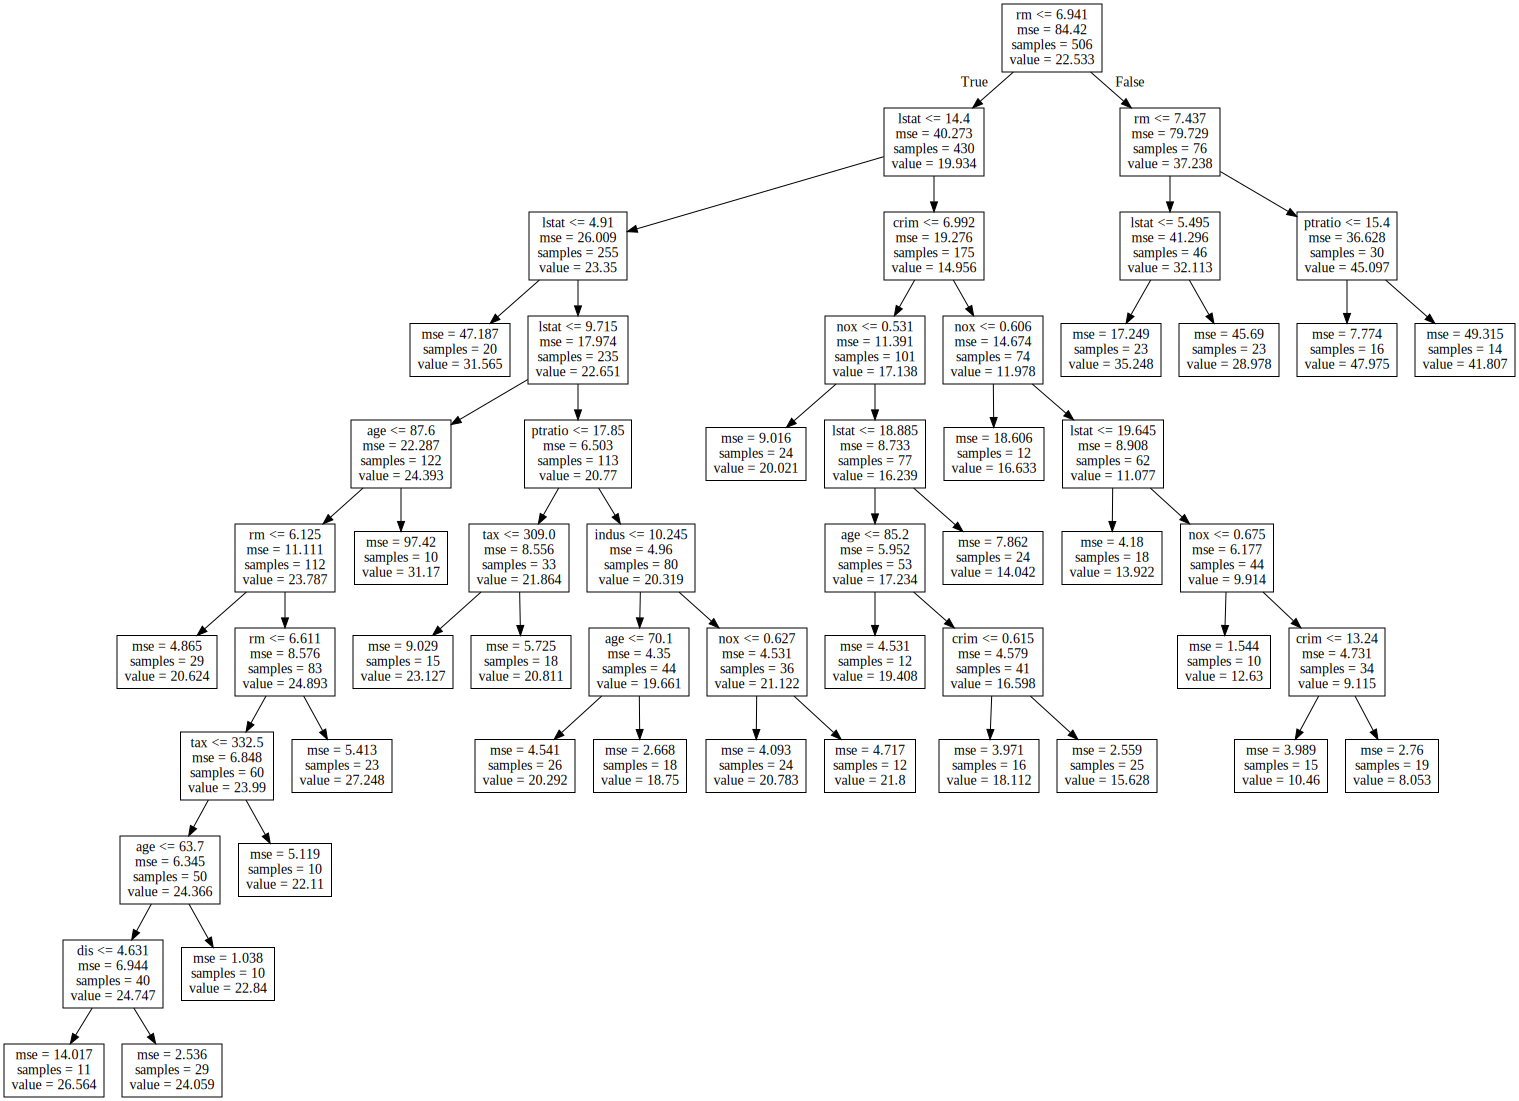

In [8]:
from sklearn.tree import export_graphviz
from graphviz import Source
import os

with open("../resources/boston_rtree.dot", 'w') as dotfile:
    export_graphviz(regtree, out_file=dotfile, feature_names=predictors)
    dotfile.close()  

file = open("../resources/boston_rtree.dot", 'r')
text = file.read()
Source(text)

### Validación cruzada

In [9]:
import numpy as np

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [10]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(regtree, X, Y, scoring="r2", cv = cv, n_jobs=1)
score = np.mean(scores)

print(score)
print(scores)

0.7581664833903177
[0.85293137 0.83493537 0.7726901  0.45227168 0.88318504 0.73121579
 0.75464413 0.67031453 0.79895153 0.83052528]


La métrica de `scoring` empleada por el profesor en el curso en su versión es `mean_squared_error` que se corresponde con la empleada en este caso `neg_mean_squared_error`.

En general, tendremos que obtener una visión en profundidad de como se comportan los datos que estamos analizando para poder decidir qué métrica es más adecuada para evaluar el error del modelo.

Para más información visitar los siguientes enlaces:
* https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
* https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0
* https://www.stat.cmu.edu/~cshalizi/350/lectures/22/lecture-22.pdf

In [11]:
scorings = sorted(metrics.SCORERS.keys())
scorings = np.array(scorings)
scorings[np.newaxis,:]

array([['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score',
        'average_precision', 'balanced_accuracy', 'brier_score_loss',
        'completeness_score', 'explained_variance', 'f1', 'f1_macro',
        'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score',
        'homogeneity_score', 'mutual_info_score', 'neg_log_loss',
        'neg_mean_absolute_error', 'neg_mean_squared_error',
        'neg_mean_squared_log_error', 'neg_median_absolute_error',
        'normalized_mutual_info_score', 'precision', 'precision_macro',
        'precision_micro', 'precision_samples', 'precision_weighted',
        'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples',
        'recall_weighted', 'roc_auc', 'v_measure_score']], dtype='<U28')

Las variables más importantes pueden ser extraídas del árbol. Su peso dentro del modelo se obtiene de `regtree.feature_importances_`. Este representa el porcentaje de reducción de la varianza que aporta cada característica sobre la varianza total.

In [12]:
list(zip(predictors, regtree.feature_importances_))

[('crim', 0.03421203230639308),
 ('zn', 0.0),
 ('indus', 0.0011605887788380146),
 ('chas', 0.0),
 ('nox', 0.01856163073811432),
 ('rm', 0.6308568014337028),
 ('age', 0.01725115143448847),
 ('dis', 0.0013745115995791378),
 ('rad', 0.0),
 ('tax', 0.0023698305298803803),
 ('ptratio', 0.009333247332530954),
 ('black', 0.0),
 ('lstat', 0.28488020584647283)]

* La más importante es `rm` (el número de habitaciones por vivienda)
* Como siguiente variable predictora aparece `lstat`
* La aportación del resto de variables a la reducción de la varianza es muy baja

## Bosque Aleatorio para regresión

Nos basamos en el mismo ejemplo para aplicar la técnica de **bosque aleatorio**.

Esta vez, como parámetros del modelo pasaremos:

* `n_jobs = 2` para el número de trabajos a ejecutar en paralelo para el ajuste o clasificación `fit` y la predicción `predict`.
* `oob_score = True` para indicar que use muestras aleatorias fueras de las bolsas (`out-of-bag`) para estimar el `R^2` en la data oculta
* `n_estimators = 10` para que ejecute 10 árboles en el bosque

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
forest = RandomForestRegressor(n_jobs=2, oob_score=True, n_estimators=10)
forest.fit(X,Y)

/Users/carlosdavila/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [16]:
data['rforest_predict'] = forest.oob_prediction_
data[['rforest_predict','medv']]

,rforest_predict,medv
0,29.800000,24.0
1,23.166667,21.6
2,34.860000,34.7
3,34.800000,33.4
4,35.920000,36.2
5,22.150000,28.7
6,20.850000,22.9
7,18.266667,27.1
8,18.585714,16.5
9,19.780000,18.9


In [17]:
data['rforest_error2'] = (data['rforest_predict'] - data['medv'])**2
sum(data['rforest_error2'])/len(data)

18.540636091112994

In [18]:
forest.oob_score_

0.780375105777444

Jugar con el número de árboles en el bosque puede mejorar la precisión de la técnica. Sin embargo no será eficiente ni necesario excederse con el número de árboles pues llegados a un punto, la eficacia del modelo no mejora sustancialmente. 

In [20]:
forest = RandomForestRegressor(n_jobs=2, oob_score=True, n_estimators=500)
forest.fit(X,Y)
data['rforest_predict'] = forest.oob_prediction_
data['rforest_error2'] = (data['rforest_predict'] - data['medv'])**2
sum(data['rforest_error2'])/len(data)

10.383597841017469

In [21]:
forest.oob_score_

0.8770000896260444